## Setup and Load Data

### 1. Setup Python Environment

This cell installs the required Python packages (`rpy2`) for running R code in this notebook.

In [ ]:
import sys
try:
    import rpy2
except ImportError:
    !{sys.executable} -m pip install rpy2

This cell loads the required Python packages (`rpy2`) for running R code in this notebook.

In [2]:
%load_ext rpy2.ipython

### 2. Load Data

In [59]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [ ]:
data = pd.read_excel("data/personal_finance_dataset.xlsx", sheet_name = "datathon_finance")
dictionary = pd.read_excel("data/personal_finance_dataset.xlsx", sheet_name = "dictionary")

## Cleaning the Dataset

### 1. Inspecting the Dataset
We inspect the dataset using shape, head, info, and describe(). All 19 columns and 16,241 rows have non-null values, indicating there are no missing entries.

In [ ]:
data.shape
data.head()
data.info()
data.describe()

data.isna().sum() # Check for missing values

### 2. Filter Age Group
Keep only respondents aged 18–54 (PAGEMIEG 1–4).

In [ ]:
# Remove the group ages not in 18-54
data = data[data['PAGEMIEG'].isin([1, 2, 3, 4])]

### 3. Classify Variables
We extract lists of binary, categorical, and continuous columns from the data dictionary.

In [ ]:
# Find binary columns
binary_cols = dictionary[dictionary['Type'] == 'Binary']['Variable Name'].tolist()
print(binary_cols)

# Find categorial columns
categorial_cols = dictionary[dictionary['Type'] == 'Categorical']['Variable Name'].tolist()
print(categorial_cols)

# Find continuous columns
continuous_cols = dictionary[dictionary['Type'] == 'Continuous']['Variable Name'].tolist()
print(continuous_cols)

### 4. Check for Unexpected Values
We check for outliers to decide what to do with those affected rows.

In [ ]:
# Binary columns
for col in binary_cols:
    print(col, sorted(data[col].unique()))

In [ ]:
# Categorical columns
for col in categorial_cols:
    print(col, sorted(data[col].unique()))

In [ ]:
# Continuous columns
for col in continuous_cols:
    print(col)
    print(data[col].describe())
    print(sorted(data[col].unique())[:10], '...', sorted(data[col].unique())[-10:])
    print()

After inspecting each column, we see there are no unexpected values, which are given from the dictionary.

### 5. Add necessary variables to the dataset
We add or transform variables needed for analysis, such as:
- Encoding categorical and binary variables into numeric form suitable for clustering.
- Scaling continuous financial variables to ensure all features are on a comparable scale.
- Creating any derived variables that summarize or combine information, if relevant (e.g., total debt, net assets).

### 6. Saving the cleaned data

In [33]:
data.to_excel('data/cleaned_financial_data.xlsx', index=False)

## Identifying Key Predictors of Financial Stress and Stability

### Load Libraries in R

In [4]:
pip install "pandas[excel]" numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%%R
library(readxl)
library(tidyverse)

dataset <- read_excel("data/personal_finance_dataset.xlsx", sheet = "datathon_finance")
print(as.data.frame(head(dataset, 20), width = Inf))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
   PAGEMIEG PATTCRU PATTSITC PATTSKP PEDUCMIE PEFATINC PFMTYPG PFTENUR PLFFPTME
1         6       4        3       2        4   115525       4       1        3
2         7       4        3       2        9   121300       2       1        3
3         5       4        3       2        4    19175       2       1        3
4         6       3        3       2        4   147425       2       2        2
5         4       4        3       2        3    56750       1       3      

Performing forward stepwise selection to determine the best model to predict the net worth of an individual.

## Building a segmentation model using clustering to find distinct financial personas
Doing segmentation using k-means clustering.

### 1. Preprocessing Data

In [60]:
# Selecting relevant features for clustering
features = data[['PAGEMIEG', 'PWNETWPG']]

In [61]:
# Standardizing the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

### 2. Make new data frame

In [62]:
plot_df = pd.DataFrame(scaled_features, columns=['PAGEMIEG', 'PWNETWPG'])
plot_df['Cluster'] = kmeans.labels_

### 3. Implementing K-means Clustering

In [63]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

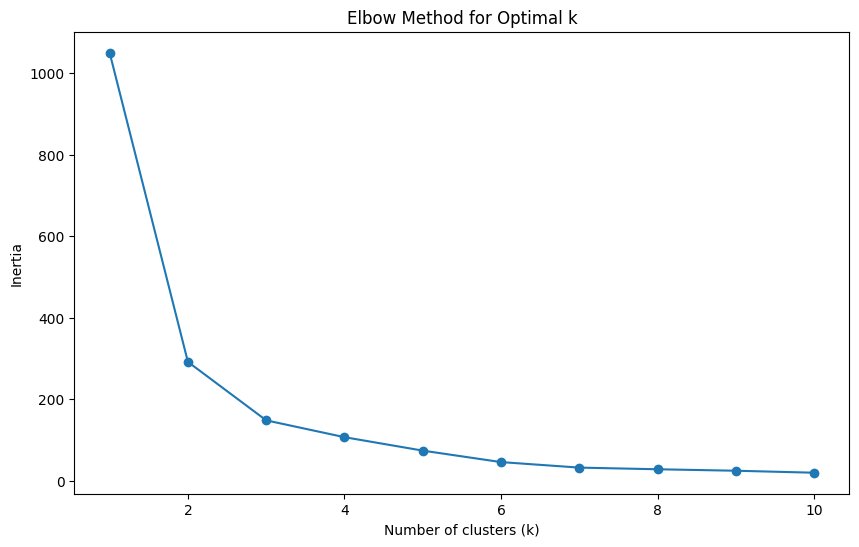

In [64]:
# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

### 3. Fitting the K-means Model

In [77]:
# Fitting K-means with the optimal number of clusters
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",2
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


### 4. Evaluating the K-means Model

In [78]:
score = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.639231109168596


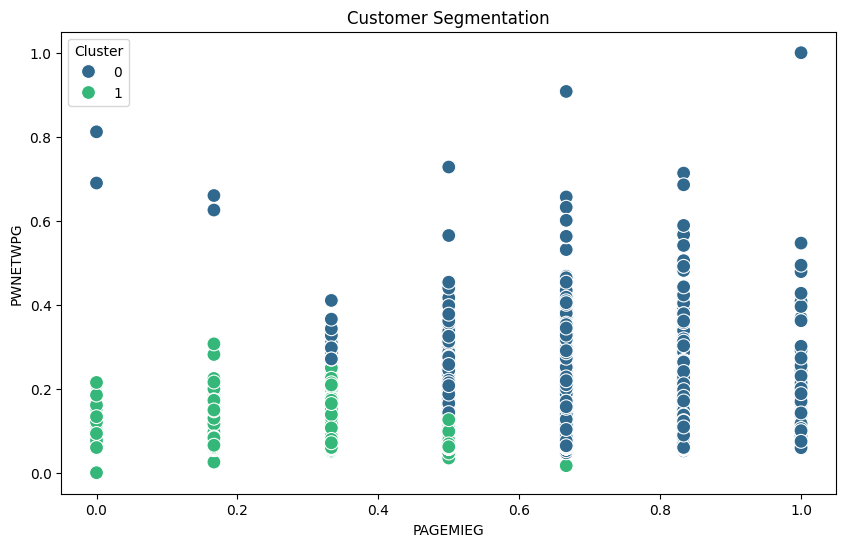

In [79]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,         # use the plotting DataFrame
    x='PAGEMIEG',         # feature 1
    y='PWNETWPG',         # feature 2
    hue='Cluster',         # color points by cluster
    palette='viridis',    # optional color map
    s=100                 # optional marker size
)
plt.title('Customer Segmentation')
plt.show()

### 5. Analyzing Segments

In [80]:
segment_analysis = data.groupby('Cluster').mean()
print(segment_analysis)
print(kmeans.cluster_centers_)

         PAGEMIEG   PATTCRU  PATTSITC   PATTSKP  PEDUCMIE       PEFATINC  \
Cluster                                                                    
0        5.704336  3.892388  2.584560  1.968511  3.189818   99914.518344   
1        3.064329  3.595171  2.279808  1.905573  3.520754  109295.319993   

          PFMTYPG   PFTENUR  PLFFPTME   PNBEARG     PPVRES       PWAPRVAL  \
Cluster                                                                     
0        2.607024  1.583284  2.402884  1.275162  35.223563  619058.784579   
1        3.220936  2.181082  1.326774  2.014883  36.923268  456155.655697   

             PWASTDEP        PWATFS       PWDPRMOR     PWDSLOAN     PWDSTCRD  \
Cluster                                                                        
0        72381.947714  53572.320973   50352.258191   623.685501  2283.236217   
1        27339.932198  20393.638168  153202.553332  3078.872995  4370.251364   

             PWDSTLOC      PWNETWPG  
Cluster                    